# ARIMA methods (Statistical)
### Notes: Covid19 dataset is seasonal 
1) visualise time series data 
2) make time series data stationary 
3) plot Autocorrelation and Correlation (ACF and PACF)
4) buiild ARIMA model and evaluate using MAE and MSE
5) predicts using ARIMA model 

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.core.pylabtools import figsize
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")


missing values in dataset: 
date         0
cases_new    0
dtype: int64
length of dataset:  1716
date         datetime64[ns]
cases_new             int64
dtype: object
            count                           mean                  min  \
date         1716  2022-05-31 12:00:00.000000256  2020-01-25 00:00:00   
cases_new  1716.0                    3097.769814                  0.0   

                           25%                  50%                  75%  \
date       2021-03-28 18:00:00  2022-05-31 12:00:00  2023-08-03 06:00:00   
cases_new                131.0                851.5               3246.5   

                           max          std  
date       2024-10-05 00:00:00          NaN  
cases_new              33406.0  5621.640214  


<Axes: xlabel='date'>

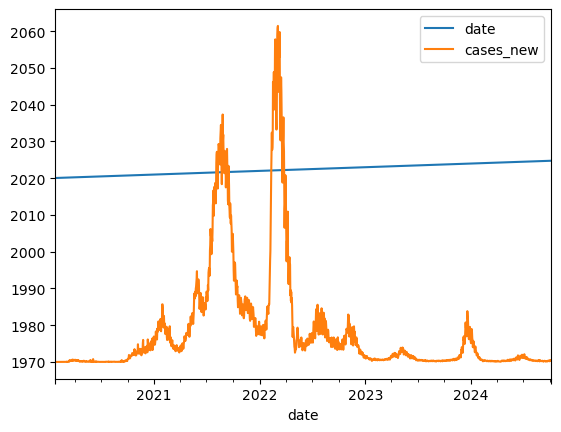

In [37]:
# Load the dataset
df = pd.read_csv('../datasets/cases_state.csv', usecols=['date', 'state', 'cases_new'])

# Convert 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'],  format='%Y-%m-%d')

# Aggregate data by date if you want to plot the total new cases across all states per day
df_grouped = df.groupby('date')['cases_new'].sum().reset_index()

#set the index as 'date'
df_grouped.index = df_grouped['date']

# Set the frequency of the DataFrame's index to daily ('D')
df_grouped = df_grouped.asfreq('D')

# Check for missing values
print("missing values in dataset: ")
print( df_grouped.isna().sum())

# Fill or drop missing values
df_grouped.fillna(0, inplace=True)

# Check the length of the dataset
print("length of dataset: ", len(df_grouped))

#check df_grouped type of data for both columns
print(df_grouped.dtypes)

#calculate the mean,std, count, min, max, 25%,50%,75%
print (df_grouped.describe().transpose())
df_grouped.plot()

### Test the data is stationary or not 
#### Dickey fuller test
##### Notes:
1) if the data is stationary, then it is already good, however if the data is non stationary, then needs to to deferencing to the data to become stationary
2) stationary means the data has a constant mean, variance, and covarinace over time. 

In [36]:
result = adfuller(df_grouped['cases_new'])

def adf_check(time_series):
    result = adfuller(time_series)
    print("Augmented Dicky Fuller Test")
    labels = ['ADF Test Statistic', 'p-values', '# of lags', 'Num of Observations used']
    #p-values should be small to be stationary
    
    for value,label in zip(result,labels):
        print (label + ":" + str(value))
        
    if result[1] <= 0.5:
        print ("Strong evidence against null hypothesis")
        print ('reject null hypothesis')
        print ("Data has no unit root and is stationary")
    else: 
        print("weak evidence against null hypothesis")
        print('fail to reject null hypothesis')
        print("Data has an unit root and is non-stationary")
        
adf_check(df_grouped['cases_new'])


Augmented Dicky Fuller Test
ADF Test Statistic:-4.320380442926939
p-values:0.00040946636330906755
# of lags:22
Num of Observations used:1687
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


Augmented Dicky Fuller Test
ADF Test Statistic:-6.906898109374877
p-values:1.2405969070781056e-09
# of lags:25
Num of Observations used:1672
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


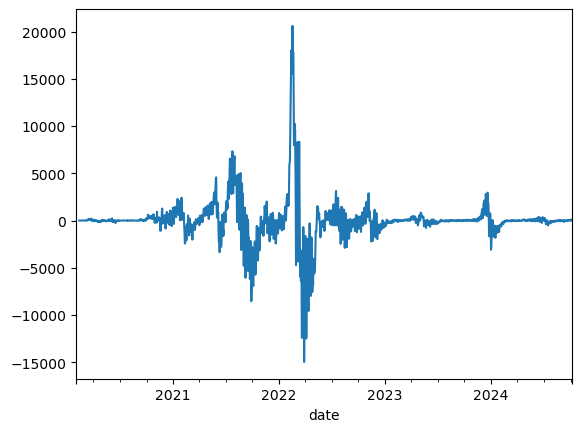

In [35]:
#Seasonal Differencing, trying to see if data is stationary by seasonal time or not
df_grouped['Seasonal Difference'] = df_grouped['cases_new'] - df_grouped['cases_new'].shift(12)
df_grouped['Seasonal Difference'].plot()
adf_check(df_grouped['Seasonal Difference'].dropna()) #dropna because we shift the data and remove one row

### Plot Autocorrelation and Partial Autocorrelation

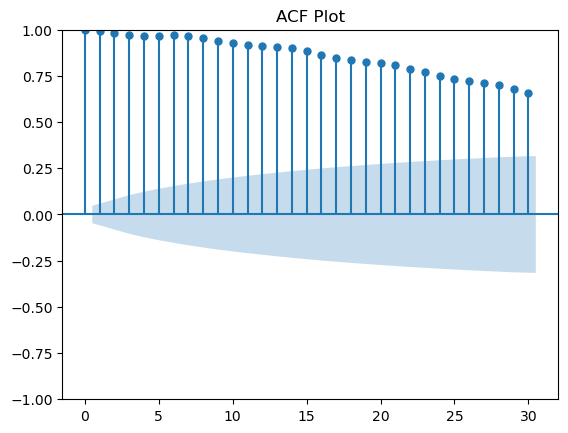

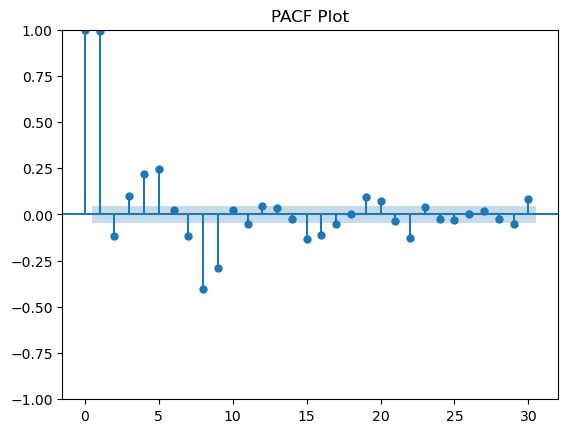

In [5]:
# Plot ACF and PACF
plot_acf(df_grouped['cases_new'], lags=30)
plt.title('ACF Plot')
plt.show()

plot_pacf(df_grouped['cases_new'], lags=30)
plt.title('PACF Plot')
plt.show()


## Predicts using ARIMA model 
### Data Preprocessing (sort data, split the data) and build ARIMA

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14639D+00    |proj g|=  1.53847D-01


 This problem is unconstrained.



At iterate    5    f=  8.05078D+00    |proj g|=  8.21469D-03

At iterate   10    f=  8.04546D+00    |proj g|=  1.00559D-03

At iterate   15    f=  8.04522D+00    |proj g|=  7.01560D-04

At iterate   20    f=  8.04315D+00    |proj g|=  1.62699D-02

At iterate   25    f=  7.94968D+00    |proj g|=  1.22435D-02

At iterate   30    f=  7.94831D+00    |proj g|=  4.58128D-03

At iterate   35    f=  7.94442D+00    |proj g|=  6.73239D-02

At iterate   40    f=  7.94073D+00    |proj g|=  5.69527D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     60      1     0     0   5.572D-05   7.941D+00
  F =   7.94069789159

<Axes: ylabel='Density'>

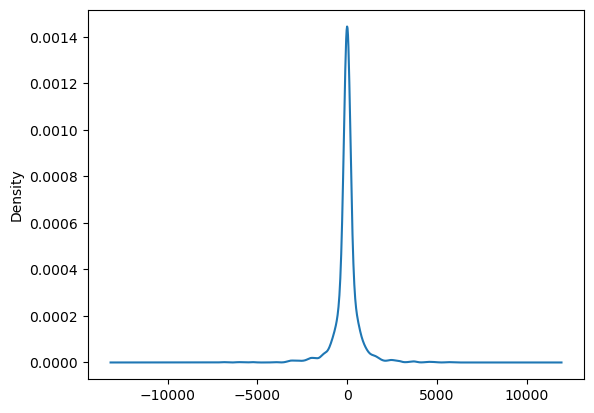

In [38]:
#Build Arima with Udemy 
#Choose the values of p and q based on the acf and pacf

#strong seasonal pattern, might increase p and q

#These values imply that: in order and seasonal order values 
# No autoregressive terms (p=0)
# Differencing (d=1)
# No moving average terms (q=0)
# The first 1 (AR term) indicates that the model uses one lag of the dependent variable.
# The second 1 (differencing) suggests you are differencing the data once, even though your ADF test indicates stationarity.
# The last 1 (MA term) indicates that the model uses one lag of the forecast errors.
# Seasonal period (s=12, which implies yearly seasonality if your data is daily)

model = sm.tsa.statespace.SARIMAX(df_grouped['cases_new'],order=(1,1,1), seasonal_order=(1,1,1,12))

results = model.fit()
print(results.summary())

# residual values has the error based off what it would predict for all original data
results.resid.plot(kind= 'kde') # the graph should be focus on central 0, less error

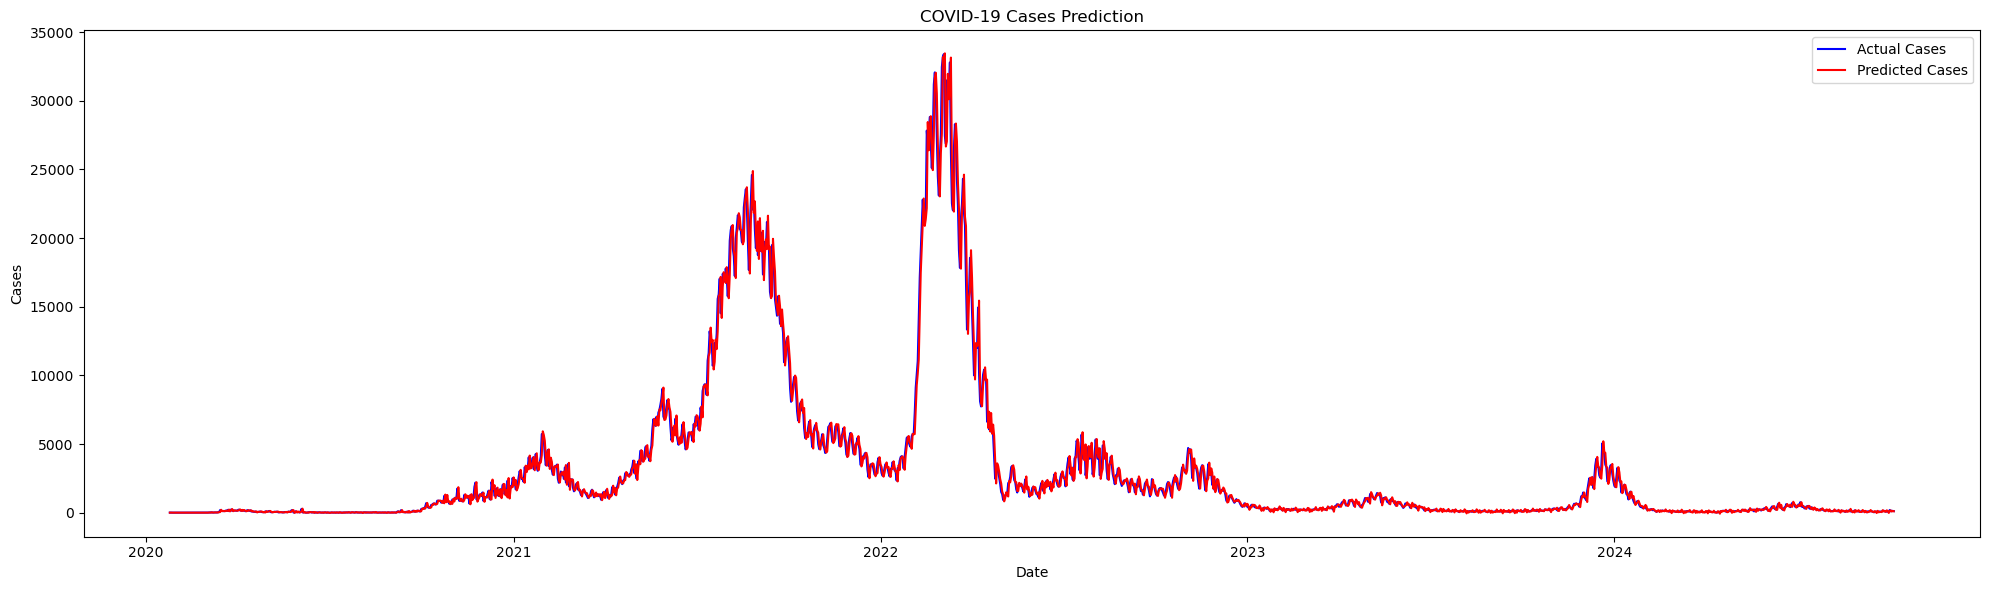

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.19045D+00    |proj g|=  9.40589D+00


 This problem is unconstrained.



At iterate    5    f= -2.21685D+00    |proj g|=  2.17193D-01

At iterate   10    f= -2.22448D+00    |proj g|=  6.77978D+00

At iterate   15    f= -2.29807D+00    |proj g|=  6.30243D-01

At iterate   20    f= -2.29954D+00    |proj g|=  2.12291D+00

At iterate   25    f= -2.33974D+00    |proj g|=  9.57566D+00

At iterate   30    f= -2.36720D+00    |proj g|=  7.45551D-02

At iterate   35    f= -2.38441D+00    |proj g|=  1.34728D+00

At iterate   40    f= -2.38982D+00    |proj g|=  5.58061D-01

At iterate   45    f= -2.39572D+00    |proj g|=  8.56563D-02

At iterate   50    f= -2.39574D+00    |proj g|=  4.71430D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [39]:
#predicts the cases starting from 2020 until 2024
df_grouped['forecast'] = results.predict(start='2020-01-25', end='2024-10-05')
# df_grouped[['cases_new', 'forecast']].plot(figsize(12,8))
# print(df_grouped.tail())
# Plot the ARIMA predictions vs actual cases
plt.figure(figsize=(20, 6))
plt.plot(df_grouped['date'], df_grouped['cases_new'], label='Actual Cases', color='blue')
plt.plot(df_grouped['date'], df_grouped['forecast'], label='Predicted Cases', color='red')
plt.title('COVID-19 Cases Prediction')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.tight_layout()
plt.show()

# Step 1: Scale the cases_new column
scaler = MinMaxScaler(feature_range=(0, 1))
df_grouped['cases_new_scaled'] = scaler.fit_transform(df_grouped[['cases_new']])

# Step 2: Fit the ARIMA model on scaled data
model_scaled = sm.tsa.statespace.SARIMAX(df_grouped['cases_new_scaled'],
                                         order=(1,1,1),
                                         seasonal_order=(1,1,1,12))
results_scaled = model_scaled.fit()

# Step 3: Generate scaled predictions
df_grouped['forecast_scaled'] = results_scaled.predict(start='2020-01-25', end='2024-10-05')

# Step 4: Calculate scaled MAE, MSE, RMSE
mae_scaled = mean_absolute_error(df_grouped['cases_new_scaled'], df_grouped['forecast_scaled'])
mse_scaled = mean_squared_error(df_grouped['cases_new_scaled'], df_grouped['forecast_scaled'])
rmse_scaled = np.sqrt(mse_scaled)
# Compute Mean Absolute Difference (MAD) for ARIMA
mad_arima = np.mean(np.abs(df_grouped['cases_new'] - df_grouped['forecast']))

print(f"Mean Absolute Difference (MAD) for ARIMA: {mad_arima}")
print(f"Scaled Mean Absolute Error (MAE): {mae_scaled}")
print(f"Scaled Mean Squared Error (MSE): {mse_scaled}")
print(f"Scaled Root Mean Squared Error (RMSE): {rmse_scaled}")


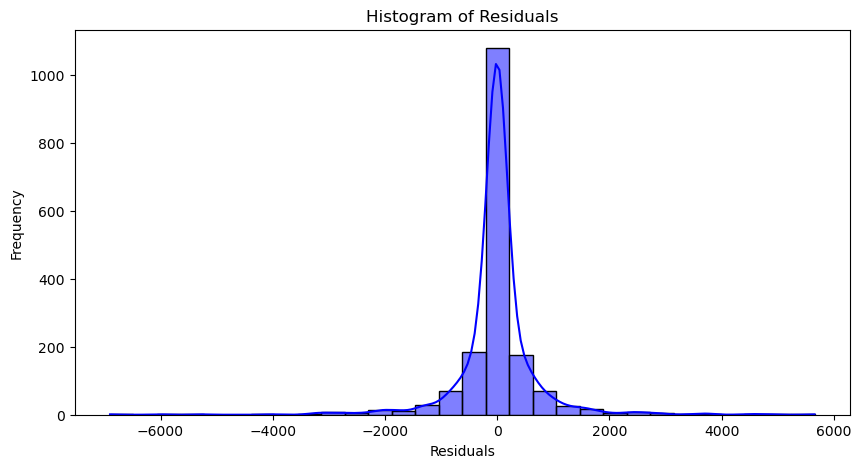

<Figure size 1200x500 with 0 Axes>

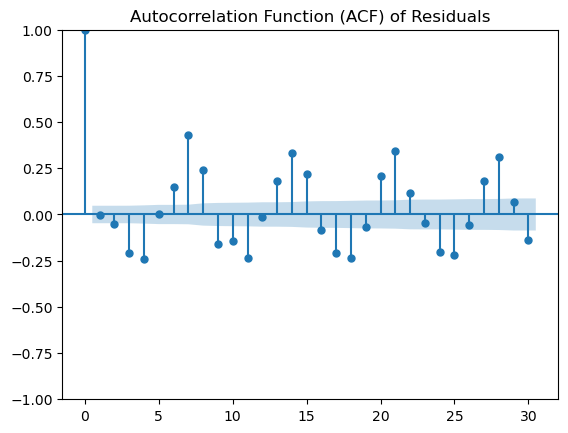

<Figure size 1200x500 with 0 Axes>

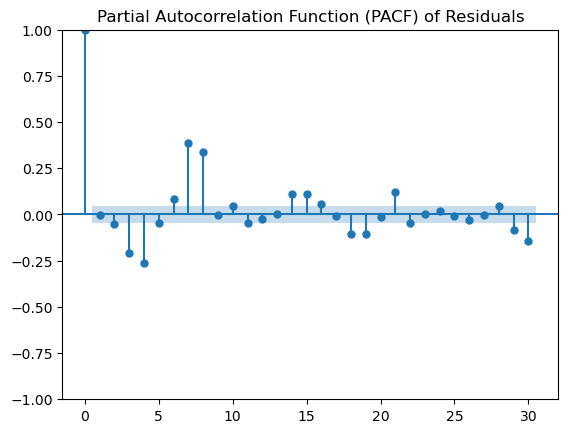

In [40]:
import seaborn as sns
import scipy.stats as stats

# Residuals (model errors)
residuals = results.resid

# Plot Histogram of Residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True, color='blue')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation (ACF) and Partial Autocorrelation (PACF) Plots
plt.figure(figsize=(12,5))
plot_acf(residuals, lags=30)
plt.title("Autocorrelation Function (ACF) of Residuals")
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(residuals, lags=30)
plt.title("Partial Autocorrelation Function (PACF) of Residuals")
plt.show()





## Testing guna Pakcik

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16692D+00    |proj g|=  1.95764D-01

At iterate    5    f=  6.06947D+00    |proj g|=  3.73016D-03

At iterate   10    f=  5.98871D+00    |proj g|=  2.46453D-02

At iterate   15    f=  5.98430D+00    |proj g|=  4.03913D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   1.643D-05   5.984D+00
  F =   5.9842136148648288     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

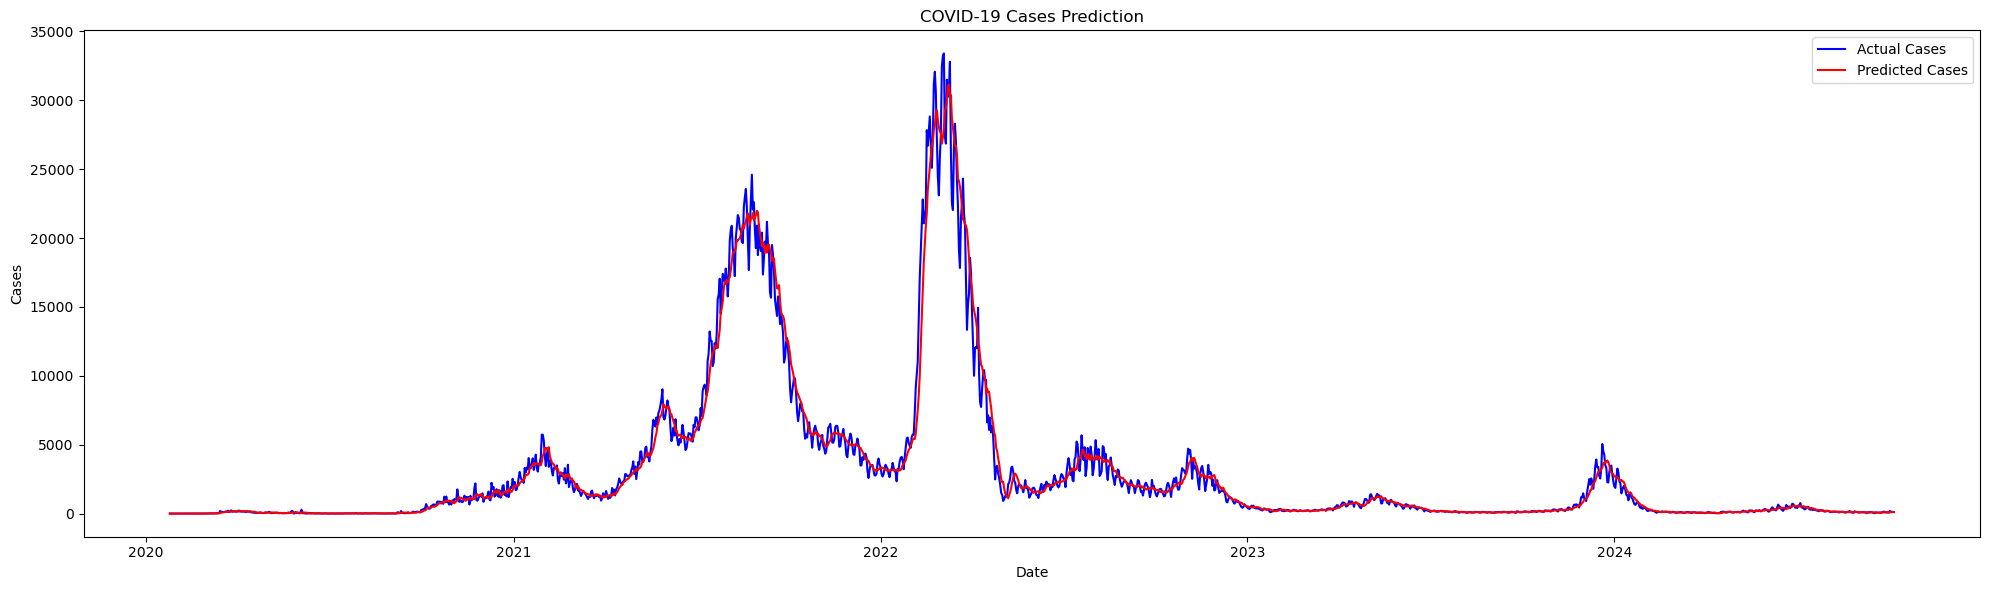

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.23418D+00    |proj g|=  1.26708D+01


 This problem is unconstrained.



At iterate    5    f= -2.28779D+00    |proj g|=  5.43835D-01

At iterate   10    f= -2.29921D+00    |proj g|=  8.35608D+00

At iterate   15    f= -2.33354D+00    |proj g|=  1.49708D-01

At iterate   20    f= -2.33472D+00    |proj g|=  2.22725D+00

At iterate   25    f= -2.36062D+00    |proj g|=  7.26559D+00

At iterate   30    f= -2.39233D+00    |proj g|=  6.83736D-01

At iterate   35    f= -2.39460D+00    |proj g|=  4.19832D-02

At iterate   40    f= -2.39476D+00    |proj g|=  4.76915D-02

At iterate   45    f= -2.39479D+00    |proj g|=  9.56235D-03

At iterate   50    f= -2.39479D+00    |proj g|=  1.54395D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [45]:
# Apply smoothing without dropping rows
df_grouped['cases_new_smoothed'] = df_grouped['cases_new'].rolling(window=7).mean().fillna(method='bfill')

# Fit SARIMA Model on Entire Smoothed Dataset
model = sm.tsa.statespace.SARIMAX(df_grouped['cases_new_smoothed'],
                                  order=(1,1,1),
                                  seasonal_order=(0,1,1,12))
results = model.fit()

print(results.summary())

# Predict on test set
# test['forecast'] = results.predict(start=test.index[0], end=test.index[-1])

# Ensure start and end exist in the index
start_date = df_grouped.index[0]
end_date = df_grouped.index[-1]

# Predict full range
df_grouped['forecast'] = results.predict(start=start_date, end=end_date)

# Plot Predictions
plt.figure(figsize=(20, 6))
plt.plot(df_grouped.index, df_grouped['cases_new'], label='Actual Cases', color='blue')
plt.plot(df_grouped.index, df_grouped['forecast'], label='Predicted Cases', color='red')
plt.title('COVID-19 Cases Prediction')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.tight_layout()
plt.show()

# Step 1: Scale the cases_new column
scaler = MinMaxScaler(feature_range=(0, 1))
df_grouped['cases_new_scaled'] = scaler.fit_transform(df_grouped[['cases_new']])

# Step 2: Fit the ARIMA model on scaled data
model_scaled = sm.tsa.statespace.SARIMAX(df_grouped['cases_new_scaled'],
                                         order=(0,1,1),
                                         seasonal_order=(0,1,1,12))
results_scaled = model_scaled.fit()

# Step 3: Generate scaled predictions
df_grouped['forecast_scaled'] = results_scaled.predict(start=start_date, end=end_date)

# Step 4: Calculate Error Metrics
mae_scaled = mean_absolute_error(df_grouped['cases_new_scaled'], df_grouped['forecast_scaled'])
mse_scaled = mean_squared_error(df_grouped['cases_new_scaled'], df_grouped['forecast_scaled'])
rmse_scaled = np.sqrt(mse_scaled)
mad_arima = np.mean(np.abs(df_grouped['cases_new'] - df_grouped['forecast']))

print(f"Mean Absolute Difference (MAD) for ARIMA: {mad_arima}")
print(f"Scaled Mean Absolute Error (MAE): {mae_scaled}")
print(f"Scaled Mean Squared Error (MSE): {mse_scaled}")
print(f"Scaled Root Mean Squared Error (RMSE): {rmse_scaled}")

# Residuals and Cross Validations


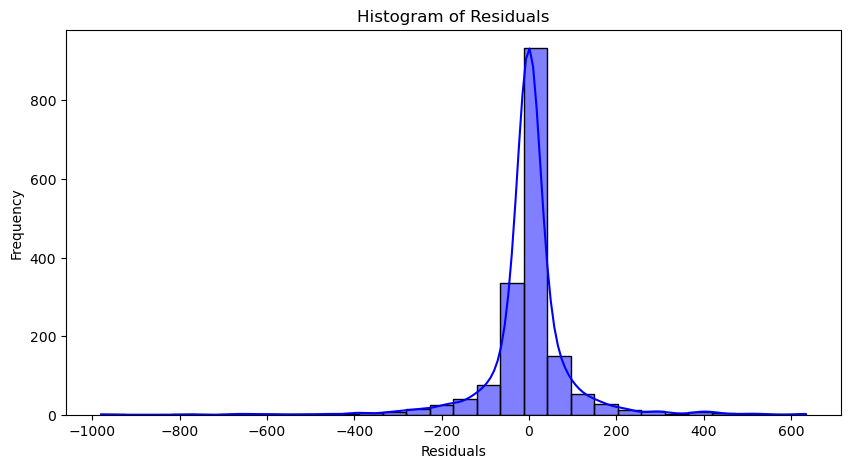

<Figure size 1200x500 with 0 Axes>

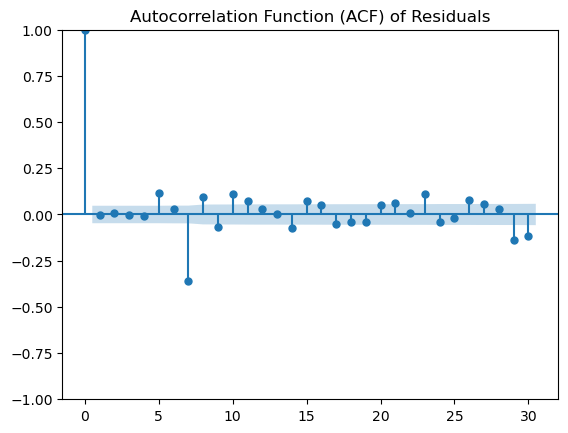

<Figure size 1200x500 with 0 Axes>

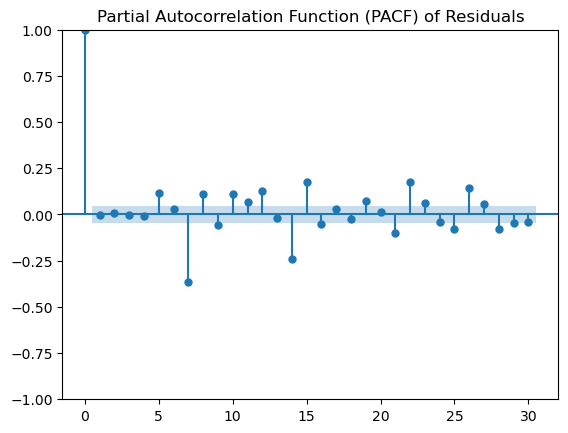

In [44]:
import seaborn as sns
import scipy.stats as stats

# Residuals (model errors)
residuals = results.resid

# Plot Histogram of Residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True, color='blue')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation (ACF) and Partial Autocorrelation (PACF) Plots
plt.figure(figsize=(12,5))
plot_acf(residuals, lags=30)
plt.title("Autocorrelation Function (ACF) of Residuals")
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(residuals, lags=30)
plt.title("Partial Autocorrelation Function (PACF) of Residuals")
plt.show()



